The idea of this test is to check if the noise model matrix B of 4S changes if the planet is in the data. Can we compute it once for contrast curves and MCMC?

In [1]:
import sys
from copy import deepcopy
from pathlib import Path
import numpy as np
import json
from applefy.detections.contrast import Contrast
import matplotlib.pyplot as plt

from fours.utils.data_handling import load_adi_data
from fours.detection_limits.applefy_wrapper import FourSDataReduction

from applefy.utils.file_handling import open_fits
from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.photometry import flux_ratio2mag, mag2flux_ratio

import torch
from fours.models.psf_subtraction import FourS

# Load the data

In [2]:
dataset_file = Path("/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/09_new_rotation_loss/x2_different_residual_creations/")
exp_id = str("0123a")
use_rotation_loss = True
lambda_reg = float(850)

In [3]:
science_data, angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=str(dataset_file),
        data_tag="object_stacked_05",
        psf_template_tag="psf_template",
        para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

# other parameters
dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale = 0.02718

# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

In [4]:
dataset_id = "0115b"

# add the fake planet
fake_planet_config_file = "/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_" + exp_id + ".json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [5]:
data_with_fake_planet = add_fake_planets(
    input_stack=deepcopy(science_data),
    psf_template=psf_template,
    parang=angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

In [6]:
planet_only = add_fake_planets(
    input_stack=np.zeros_like(science_data),
    psf_template=psf_template,
    parang=angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

# Mask the planet and comput the clean mean

In [7]:
clean_mean = np.mean(data_with_fake_planet[-8000:-2000], axis=0)

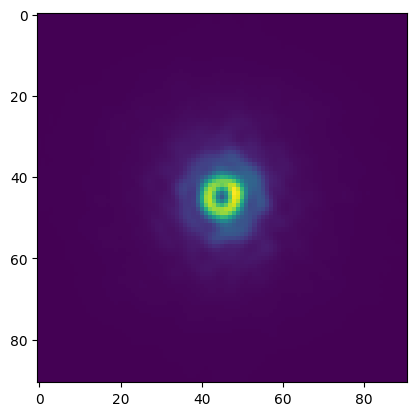

In [8]:
plt.imshow(clean_mean)

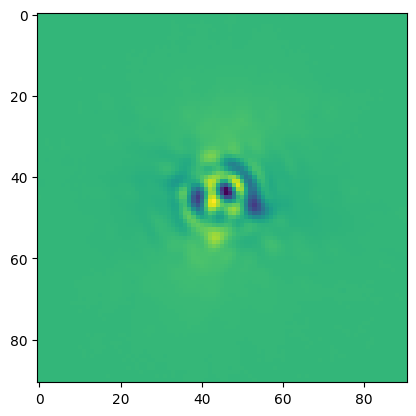

In [9]:
plt.imshow(clean_mean - np.mean(data_with_fake_planet, axis=0))

In [10]:
np.max(clean_mean - np.mean(data_with_fake_planet, axis=0))

239.11958846826383

## Train 4S on the data without the fake planet

In [233]:
experiment_root_dir = Path("/fast/mbonse/s4/70_results/test_fast_science_intercept/")
experiment_root_dir.mkdir(exist_ok=True)

In [234]:
fours_model = FourS(
    science_cube=data_with_fake_planet,
    adi_angles=angles,
    psf_template=psf_template,
    device=0,
    work_dir=experiment_root_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda=10000,
    psf_fwhm=3.6,
    right_reason_mask_factor=1.5)

In [235]:
fours_model.normalization_model.mean_frame.data = torch.zeros_like(torch.from_numpy(clean_mean).float())

In [236]:
fours_model.fit_noise_model(
    num_epochs=100,
    training_name="Remove_later_mean",
    fit_intercept=False,
    logging_interval=10)

S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]


# classi

In [260]:
out, residual_sequence = fours_model._get_residual_sequence()

In [237]:
# 0.) Normalize the science data
x_norm = fours_model.normalization_model(fours_model.science_cube)
science_norm_flatten = x_norm.view(x_norm.shape[0], -1)

# 1.) run the forward path of the noise model
fours_model.noise_model.compute_betas()
noise_estimate = fours_model.noise_model(science_norm_flatten)

# 2.) compute the residual and rotate it
residual_sequence = science_norm_flatten - noise_estimate

residual_sequence = residual_sequence.view(
    residual_sequence.shape[0],
    1,
    fours_model.data_image_size,
    fours_model.data_image_size)

In [257]:
residual_sequence.shape

torch.Size([11593, 1, 91, 91])

In [258]:
#mean_frame = angle_weighted_average(
#    residual_sequence.detach().numpy().squeeze(),
#    angles)

mean_frame = torch.mean(residual_sequence, axis=0)
#mean_frame = torch.median(residual_sequence, axis=0)[0]
#mean_frame = torch.median(residual_sequence[-7000:-2000], axis=0)[0]

residual_sequence_mean_sub = residual_sequence# - torch.tensor(mean_frame).float()

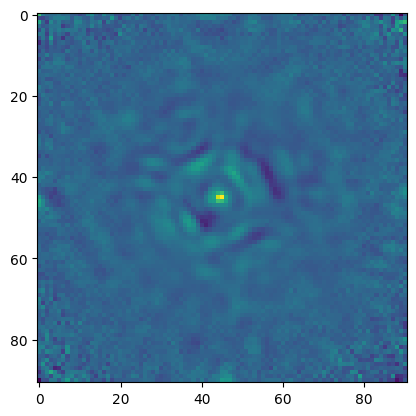

In [259]:
plt.imshow(mean_frame[0].detach().numpy())#, vmin=-0.05, vmax=0.05)

In [253]:
rotated_residual_sequence = fours_model.rotation_model(
            residual_sequence_mean_sub,
            parang_idx=torch.arange(len(residual_sequence)))

In [263]:
#mean_residual = torch.mean(rotated_residual_sequence, axis=0)[0]
mean_residual = torch.mean(out, axis=0)[0]

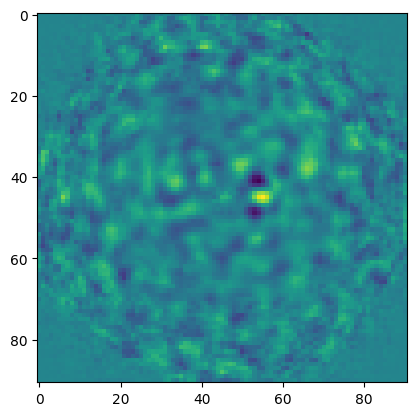

In [264]:
plt.imshow(mean_residual.detach().numpy())

In [265]:
np.max(mean_residual.detach().numpy())

0.07046777

In [206]:
from scipy.signal import medfilt

def angle_weighted_average(
    science_frames,
    parang
):
    
    delta_angle = parang[:-1] - parang[1:]
    delta_angle = medfilt(delta_angle, 41)
    delta_angle = delta_angle**2
    delta_angle /= np.sum(delta_angle)
    
    mean_frame = np.sum(science_frames[:-1] * 
                        delta_angle[:, np.newaxis, np.newaxis], axis=0)
    
    return mean_frame

# Implement different residuals

In [266]:
from typing import Union
from pathlib import Path
from datetime import datetime

import numpy as np
from tqdm.auto import tqdm

import torch
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from fours.models.noise import FourSNoise
from fours.models.normalization import FourSFrameNormalization
from fours.models.rotation import FieldRotationModel

from fours.utils.data_handling import save_as_fits
from fours.utils.logging import normalize_for_tensorboard
from fours.utils.fwhm import get_fwhm
from fours.utils.adi_tools import combine_residual_stack


class FourS:

    def __init__(
            self,
            science_cube,
            adi_angles,
            psf_template,
            noise_model_lambda,
            psf_fwhm=None,
            right_reason_mask_factor=1.5,
            rotation_grid_subsample=1,
            device=0,
            work_dir=None,
            verbose=True,
    ):
        # 0.) If some parameters are not given, set them to default values
        if psf_fwhm is None:
            psf_fwhm = get_fwhm(psf_template)
        right_reason_mask_radius = psf_fwhm * right_reason_mask_factor

        # 1.) Save all member data
        self.right_reason_mask_factor = right_reason_mask_factor
        self.device = device
        self.verbose = verbose
        self.adi_angles = adi_angles
        self.science_cube = torch.from_numpy(science_cube).float()
        self.psf_template = psf_template
        self.data_image_size = self.science_cube.shape[-1]

        if work_dir is not None:
            self.work_dir = Path(work_dir)
        else:
            self.work_dir = None
        self.residuals_dir, self.tensorboard_dir, self.models_dir = \
            self._setup_work_dir()

        # 2.) Create the noise model
        self.noise_model = FourSNoise(
            data_image_size=self.data_image_size,
            psf_template=self.psf_template,
            lambda_reg=noise_model_lambda,
            cut_radius_psf=psf_fwhm,
            right_reason_mask_radius=right_reason_mask_radius,
            convolve=True).float()

        # 2.1) Create the rotation model
        self.rotation_model = FieldRotationModel(
            all_angles=self.adi_angles,
            input_size=self.data_image_size,
            subsample=rotation_grid_subsample,
            inverse=False,
            register_grid=True).float()

        # 3.) Create normalization model
        self.normalization_model = FourSFrameNormalization(
            image_size=self.data_image_size,
            normalization_type="normal").float()
        self.normalization_model.prepare_normalization(
            science_data=self.science_cube)

        # 5.) Create the tensorboard logger for the fine_tuning
        self.tensorboard_logger = None
        self.fine_tune_start_time = None

    @classmethod
    def create_from_checkpoint(
            cls,
            noise_model_file: str,
            normalization_model_file: Union[str, Path, None],
            s4_work_dir: Union[str, Path, None],
            science_cube: np.ndarray,
            adi_angles: np.ndarray,
            psf_template: np.ndarray,
            device: Union[int, str],
            verbose: bool = True):

        # create the s4 model
        s4_model = cls(
            science_cube=science_cube,
            adi_angles=adi_angles,
            psf_template=psf_template,
            noise_cut_radius_psf=1,  # will be restored
            noise_mask_radius=1,  # will be restored
            device=device,
            negative_wing_suppression=False,  # will be restored
            noise_model_convolve=True,  # will be restored
            noise_normalization="normal",  # will be restored
            work_dir=s4_work_dir,
            verbose=verbose)

        # restore the noise and normalization model
        s4_model.restore_models(
            file_noise_model=noise_model_file,
            file_normalization_model=normalization_model_file,
            verbose=verbose)

        return s4_model

    @staticmethod
    def _print_progress(msg):
        def decorator(function):
            def wrapper(self, *args, **kwargs):
                if self.verbose:
                    print(msg + " ... ", end='')
                    result = function(self, *args, **kwargs)
                    print("[DONE]")
                else:
                    result = function(self, *args, **kwargs)
                return result
            return wrapper
        return decorator

    def _setup_work_dir(self):
        if self.work_dir is None:
            return None, None, None

        # make sure the working dir is a dir
        self.work_dir.mkdir(exist_ok=True)

        residuals_dir = self.work_dir / "residuals"
        tensorboard_dir = self.work_dir / "tensorboard"
        models_dir = self.work_dir / "models"

        residuals_dir.mkdir(exist_ok=True)
        tensorboard_dir.mkdir(exist_ok=True)
        models_dir.mkdir(exist_ok=True)

        return residuals_dir, tensorboard_dir, models_dir

    @_print_progress("4S model: saving model")
    def save_models(
            self,
            file_name_noise_model,
            file_name_normalization_model):

        if self.models_dir is None:
            raise FileNotFoundError(
                "Saving the model requires a work directory.")

        self.normalization_model.save(
            self.models_dir / file_name_normalization_model)
        self.noise_model.save(
            self.models_dir / file_name_noise_model)

    @_print_progress("4S model: restoring models")
    def restore_models(
            self,
            file_noise_model=None,
            file_normalization_model=None):

        if file_noise_model is not None:
            self.noise_model = FourSNoise.load(file_noise_model)

        if file_normalization_model is not None:
            self.normalization_model = FourSFrameNormalization.load(
                file_normalization_model)

    def _logg_loss_values(
            self,
            epoch,
            loss_recon,
            loss_reg):

        if self.work_dir is None:
            return

        self.tensorboard_logger.add_scalar(
            "Loss/Reconstruction_loss",
            loss_recon,
            epoch)

        self.tensorboard_logger.add_scalar(
            "Loss/Regularization_loss",
            loss_reg,
            epoch)

    def _logg_residuals(
            self,
            epoch,
            residual_mean,
            residual_median,
            training_name):

        self.tensorboard_logger.add_image(
            "Images/Residual",
            normalize_for_tensorboard(residual_mean),
            epoch,
            dataformats="HW")

        self.tensorboard_logger.add_image(
            "Images/Residual_Median",
            normalize_for_tensorboard(residual_median),
            epoch,
            dataformats="HW")

        self.tensorboard_logger.add_image(
            "Images/Intercept",
            normalize_for_tensorboard(
                (self.noise_model.intercept**2).detach().cpu().numpy()),
            epoch,
            dataformats="HW")

        tmp_residual_dir = self.residuals_dir / \
            Path(training_name + "_" + self.fine_tune_start_time)
        tmp_residual_dir.mkdir(exist_ok=True)

        save_as_fits(
            residual_mean,
            tmp_residual_dir /
            Path("Residual_Mean_epoch_" + str(epoch).zfill(4)
                 + ".fits"),
            overwrite=True)

        save_as_fits(
            residual_median,
            tmp_residual_dir /
            Path("Residual_Median_epoch_" + str(epoch).zfill(4)
                 + ".fits"),
            overwrite=True)

    def _create_tensorboard_logger(self, training_name):
        time_str = datetime.now().strftime("%Y-%m-%d-%Hh%Mm%Ss")
        self.fine_tune_start_time = time_str
        current_logdir = self.tensorboard_dir / \
            Path(training_name + "_" + self.fine_tune_start_time)
        current_logdir.mkdir()
        self.tensorboard_logger = SummaryWriter(current_logdir)

    def _get_residual_sequence(self):
        # 0.) Normalize the science data
        x_norm = self.normalization_model(self.science_cube)
        science_norm_flatten = x_norm.view(x_norm.shape[0], -1)

        # 1.) run the forward path of the noise model
        self.noise_model.compute_betas()
        noise_estimate = self.noise_model(science_norm_flatten)

        # 2.) compute the residual and rotate it
        residual_sequence = science_norm_flatten - noise_estimate
        residual_sequence = residual_sequence.view(
            residual_sequence.shape[0],
            1,
            self.data_image_size,
            self.data_image_size)
        
        # new code
        residual_sequence_mean_rem = residual_sequence - torch.mean(residual_sequence, axis=0)

        rotated_residual_sequence = self.rotation_model(
            residual_sequence_mean_rem,
            parang_idx=torch.arange(len(residual_sequence)))

        return rotated_residual_sequence, residual_sequence

    @_print_progress("S4 model: Fit noise model")
    def fit_noise_model(
            self,
            num_epochs,
            training_name="",
            logging_interval=1,
            fit_intercept=False,
            optimizer=None,
            optimizer_kwargs=None):

        # 1.) Create the tensorboard logger
        if self.work_dir is not None:
            self._create_tensorboard_logger(training_name)

        # 2.) move models to the GPU
        self.noise_model = self.noise_model.to(self.device)
        self.rotation_model = self.rotation_model.to(self.device)
        self.science_cube = self.science_cube.to(self.device)
        self.normalization_model = self.normalization_model.to(self.device)

        # 3.) Create the optimizer and add the parameters we want to optimize
        trainable_params = [self.noise_model.betas_raw, ]
        if fit_intercept:
            trainable_params.append(self.noise_model.intercept)

        if optimizer is not None:
            optimizer = optimizer(
                trainable_params,
                **optimizer_kwargs)
        else:
            if optimizer_kwargs is None:
                optimizer_kwargs = {
                    "max_iter": 20,
                    "history_size": 10}

            optimizer = optim.LBFGS(
                trainable_params,
                **optimizer_kwargs)

        # 4.) Run the optimization
        for epoch in tqdm(range(num_epochs)):

            def full_closure(compute_residuals):
                optimizer.zero_grad()

                # 4.1) Get the residual sequence
                rotated_residual_sequence, residual_sequence = (
                    self._get_residual_sequence())

                # 4.2) Compute the loss
                loss_recon = torch.var(rotated_residual_sequence, axis=0).sum()
                loss_recon *= rotated_residual_sequence.shape[0]

                loss_reg = (self.noise_model.betas_raw ** 2).sum() \
                    * self.noise_model.lambda_reg

                # 4.3) Backward
                loss = loss_recon + loss_reg
                loss.backward()

                if compute_residuals:
                    residual = torch.mean(
                        rotated_residual_sequence, axis=0)[
                        0].detach().cpu().numpy()
                    residual_median = torch.median(
                        rotated_residual_sequence, axis=0)[0][
                        0].detach().cpu().numpy()

                    return loss_recon, loss_reg, residual, residual_median
                else:
                    return loss, loss_recon, loss_reg

            def loss_closure():
                return full_closure(False)[0]

            optimizer.step(loss_closure)

            # 5.) Logg the information
            if epoch % logging_interval == 0:
                # Logg the full information with residuals
                # x.) get current residuals
                current_loss_recon, \
                    current_loss_reg, \
                    current_residual, \
                    current_residual_median = full_closure(True)

                self._logg_residuals(
                    epoch=epoch,
                    residual_mean=current_residual,
                    residual_median=current_residual_median,
                    training_name=training_name)

                self._logg_loss_values(
                    epoch=epoch,
                    loss_recon=current_loss_recon,
                    loss_reg=current_loss_reg)

            else:
                # Logg the loss information
                _, current_loss_recon, current_loss_reg = full_closure(False)

        # 7.) Clean up GPU
        self.noise_model = self.noise_model.cpu()
        self.rotation_model = self.rotation_model.cpu()
        self.normalization_model = self.normalization_model.cpu()
        self.science_cube = self.science_cube.cpu()
        torch.cuda.empty_cache()

    @_print_progress("S4 model: computing residual")
    @torch.no_grad()
    def compute_residuals(self, num_cpus=4):

        # 1.) Get the residual sequence
        rotated_residual_sequence, residual_sequence = (
            self._get_residual_sequence())

        # 2.) Compute the residual image (mean)
        mean_residual = torch.mean(rotated_residual_sequence,
                                   axis=0)[0].cpu().numpy()

        # 3.) Compute the residual image (median)
        median_residual = torch.median(rotated_residual_sequence,
                                       axis=0)[0][0].cpu().numpy()

        return mean_residual, median_residual
